In [18]:
import torch
import numpy as np
from matplotlib import pyplot as plt
dtype = torch.float
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

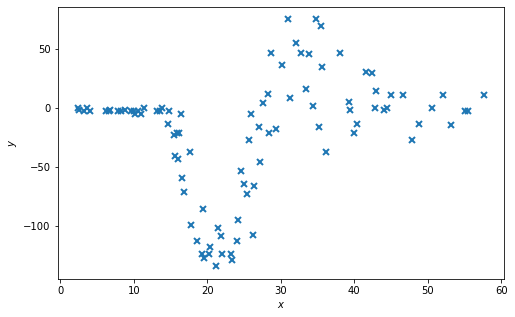

In [19]:
data = np.loadtxt('motor.dat')
X = data[:, 0][:, None]
Y = data[:, 1][:, None]
N = len(X)
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

In [20]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H, D_out = 1, 200, 1

In [21]:
class NeuralNetwork(nn.Module):
    """
    An implementation of a fully connected feed forward 
    Neural network in pytorch. 
    """
    def __init__(self, layersizes=[1, 1], 
                 activation=torch.relu,
                 final_layer_activation=None):
        """
        INPUTS:
            layersizes <list/tuple>: An iterable ordered object containing
                                 the sizes of the tensors from the
                                 input layer to the final output. 
                                 (See example below). 
            activation <callable>: A python callable through which
                                    torch backpropagation is possible.
            final_layer_activation <callable>: A python callable for 
                                    the final layer activation function.
                                    Default: None (for regression problems)
        
        EXAMPLE: 
            To define a NN with an input of size 2, 2 hidden layers of size 
            50 and 50, output of size 1, with tanh activation function: 
            >> layers = [2, 50, 50, 1]
            >> neuralnet = NeuralNet(layers, activation=torch.tanh)
            >> x = torch.randn(100, 2)   # 100 randomly sampled inputs 
            >> output = neuralnet(x)  # compute the prediction at x.
        
        Inheriting from nn.Module ensures that all
        NN layers defined within the __init__ function are captured and 
        stored in an OrderedDict object for easy accesability.
        """
        super(NeuralNetwork, self).__init__()
        self.layersizes = layersizes
        self.input_dim = self.layersizes[0]
        self.hidden_sizes = self.layersizes[1:-1]
        self.output_dim = self.layersizes[-1]
        self.activation = activation
        self.final_layer_activation = final_layer_activation
        if self.final_layer_activation is None:
            self.final_layer_activation = nn.Identity()
        self.nlayers = len(self.hidden_sizes) + 1
        self.layernames = [] ## Dictionary to store all the FC layers 
        
        # define FC layers
        for i in range(self.nlayers):
            layername = 'fc_{}'.format(i+1)
            layermodule = nn.Linear(self.layersizes[i], self.layersizes[i+1])
            self.layernames.append(layername)
            setattr(self, layername, layermodule)
        
    def forward(self, x):
        """
        Implement the forward pass of the NN. 
        """
        for i, layername in enumerate(self.layernames):
            fclayer = getattr(self, layername)
            x = fclayer(x)
            if i == self.nlayers - 1:
                x = self.final_layer_activation(x)
            else:
                x = self.activation(x)
        return x

In [22]:
# model = NeuralNetwork([1, 20, 20, 1], torch.tanh)
# x = torch.linspace(0., 1., 100)[:, None]
# for m in model.modules():
#     print(m)

In [23]:
# # Use the nn package to define our model and loss function.
# model = torch.nn.Sequential(
#     torch.nn.Linear(D_in, H),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H, H),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H, D_out),
# )
mse = torch.nn.MSELoss()

# instantiate the network 
layersizes = [1, 20, 20, 1]
activation = torch.tanh
model = NeuralNetwork(layersizes=layersizes, 
                    activation=activation)

## L2 regularization
lmbda = 1e-3 # reg. constant 
def L2loss(lmbda, model):
    reg = torch.tensor(0.)
    for m in model.modules():
        if hasattr(m, 'weight'):
            reg += m.weight.norm()**2
    return lmbda*reg

In [24]:
Ntrain = int(0.7*N)
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, train_size=Ntrain)

# scale the data
xscaler = StandardScaler()
yscaler = StandardScaler()
Xtrain=xscaler.fit_transform(Xtrain)
Ytrain=yscaler.fit_transform(Ytrain)
Xval, Yval = xscaler.transform(Xval), yscaler.transform(Yval)

In [32]:
batchsize = 40
np.sort(np.random.randint(0, len(Xtrain), batchsize))

array([ 3,  3,  4,  4,  6,  8, 11, 12, 16, 18, 19, 20, 20, 21, 21, 21, 22,
       27, 27, 28, 28, 29, 33, 33, 35, 36, 36, 37, 37, 37, 43, 46, 51, 53,
       56, 57, 58, 61, 61, 62])

In [26]:
print(Xtrain.shape)

(65, 1)


In [12]:
batchsize = 32
Xtrain, Ytrain = torch.Tensor(Xtrain), torch.Tensor(Ytrain)
Xval, Yval = torch.Tensor(Xval), torch.Tensor(Yval)
best_stat_dict = model.state_dict()
best_val_mse_loss = np.inf

# defining optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for i in range(5000):
    
    batchidx = np.random.randint(0, len(Xtrain), batchsize)
    xbatch, ybatch = Xtrain[batchidx], Ytrain[batchidx]
    
    # Forward pass: compute predicted y by passing x to the model.
    ypred = model(xbatch)

    # Compute and print regularized loss.
    loss = mse(ypred, ybatch) + L2loss(lmbda, model)
#     if t % 100 == 99:
#         print(t, loss.item())

    # zero out gradient buffers
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
        # print progress 
    if (i+1)%100 == 0:
        val_mse_loss = mse(Yval, model(Xval))
        print(' [Iteration %4d] Validation MSE loss: %.3f'%(i+1, val_mse_loss))
        if val_mse_loss < best_val_mse_loss:
            best_state_dict = model.state_dict()
model.load_state_dict(best_stat_dict);

 [Iteration  100] Validation MSE loss: 0.260
 [Iteration  200] Validation MSE loss: 0.208
 [Iteration  300] Validation MSE loss: 0.211
 [Iteration  400] Validation MSE loss: 0.213
 [Iteration  500] Validation MSE loss: 0.202
 [Iteration  600] Validation MSE loss: 0.198
 [Iteration  700] Validation MSE loss: 0.184
 [Iteration  800] Validation MSE loss: 0.214
 [Iteration  900] Validation MSE loss: 0.181
 [Iteration 1000] Validation MSE loss: 0.208
 [Iteration 1100] Validation MSE loss: 0.205
 [Iteration 1200] Validation MSE loss: 0.185
 [Iteration 1300] Validation MSE loss: 0.183
 [Iteration 1400] Validation MSE loss: 0.181
 [Iteration 1500] Validation MSE loss: 0.180
 [Iteration 1600] Validation MSE loss: 0.177
 [Iteration 1700] Validation MSE loss: 0.191
 [Iteration 1800] Validation MSE loss: 0.208
 [Iteration 1900] Validation MSE loss: 0.199
 [Iteration 2000] Validation MSE loss: 0.213
 [Iteration 2100] Validation MSE loss: 0.229
 [Iteration 2200] Validation MSE loss: 0.180
 [Iteratio

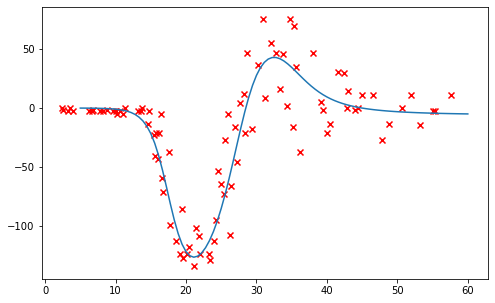

In [17]:
x_test = torch.tensor(xscaler.transform(np.linspace(5,60,100)[:,None]), dtype=dtype)
y_test = model(x_test)
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(xscaler.inverse_transform(x_test.detach().numpy()), yscaler.inverse_transform(y_test.detach().numpy()))
ax.scatter(X, Y, marker='x', c='r')